Notebook for assessing stop/start and dfco impacts

In [199]:
import sys
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
# sns.set(font_scale=2, style='whitegrid')

sns.set()

%matplotlib inline

In [200]:
# local modules
from fastsim import simdrive, cycle, vehicle

In [201]:
t0 = time.time()
# cyc = cycle.Cycle(cyc_dict=
#                   cycle.clip_by_times(cycle.Cycle("udds").get_cyc_dict(), 130))
cyc = cycle.Cycle('udds')
cyc_jit = cyc.get_numba_cyc()
print(f"Elapsed time: {time.time() - t0:.3e} s")

Elapsed time: 3.391e-02 s


In [202]:
t0 = time.time()
veh0 = vehicle.Vehicle(1).get_numba_veh()
print(f"Elapsed time: {time.time() - t0:.3e} s")

Elapsed time: 4.887e-02 s


In [203]:
t0 = time.time()
# veh1 = vehicle.Vehicle(28).get_numba_veh()
veh1 = vehicle.Vehicle(1)
veh1.stopStart = True
veh1.maxMotorKw = 1
veh1.maxEssKw = 5
veh1.maxEssKwh = 1
veh1.set_init_calcs()
veh1.vehKg = veh0.vehKg
veh1 = veh1.get_numba_veh()
print(f"Elapsed time: {time.time() - t0:.3e} s")

Elapsed time: 3.790e-02 s


In [204]:
t0 = time.time()
sim_drive0 = simdrive.SimDriveJit(cyc_jit, veh0)
sim_drive0.sim_drive()
sim_drive1 = simdrive.SimDriveJit(cyc_jit, veh1)
sim_drive1.sim_drive()
print(f"Elapsed time: {time.time() - t0:.3e} s")

Elapsed time: 1.596e-02 s


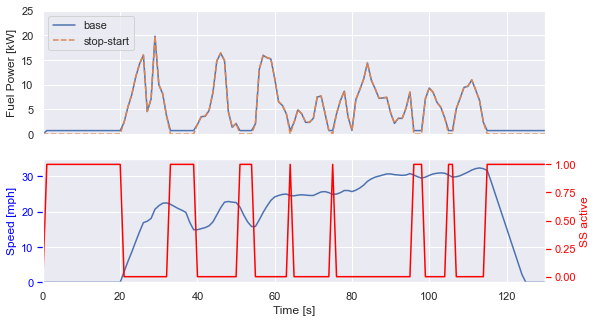

In [205]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(9,5))
ax0.plot(cyc.cycSecs, sim_drive0.fcKwOutAch, 
         label='base')
ax0.plot(cyc.cycSecs, sim_drive1.fcKwOutAch, 
         label='stop-start', linestyle='--')
# ax.plot(cyc.cycSecs, dfco_fcKwOutAchPos, label='dfco', linestyle='--', color='blue')
ax0.legend(loc='upper left')
ax0.set_ylabel('Fuel Power [kW]')
ax0.set_ylim([0, 25])

ax2 = ax1.twinx()
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.plot(cyc.cycSecs, sim_drive1.canPowerAllElectrically, 
        color='red')
ax2.set_ylabel('SS active')
ax2.set_xlim(ax0.get_xlim())
ax2.grid()

ax1.plot(cyc.cycSecs, cyc.cycMph)
ax1.yaxis.label.set_color('blue')
ax1.tick_params(axis='y', colors='blue')
ax1.set_ylabel('Speed [mph]')
ax1.set_ylim([0, 35])
ax1.set_xlabel('Time [s]')

ax1.set_xlim([0, 130])
plt.savefig('plots/stop-start-power.svg')

Stop/start produces a 5.42% reduction in fuel consumption.



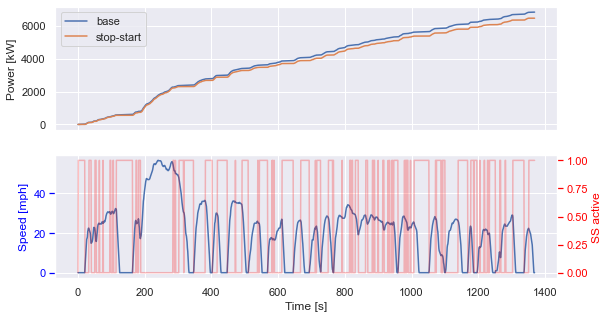

In [206]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(9,5))
ax0.plot(cyc.cycSecs, (sim_drive0.fcKwOutAch * cyc.secs).cumsum(), 
         label='base')
ax0.plot(cyc.cycSecs, (sim_drive1.fcKwOutAch * cyc.secs).cumsum(), 
         label='stop-start')
ax0.legend(loc='upper left')
ax0.set_ylabel('Power [kW]')

ax2 = ax1.twinx()
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.plot(cyc.cycSecs, sim_drive1.canPowerAllElectrically, 
        color='red', alpha=0.25)
ax2.set_ylabel('SS active')
ax2.set_xlim(ax0.get_xlim())
ax2.grid()

ax1.plot(cyc.cycSecs, cyc.cycMph)
ax1.yaxis.label.set_color('blue')
ax1.tick_params(axis='y', colors='blue')
ax1.set_ylabel('Speed [mph]')
ax1.set_xlabel('Time [s]')

plt.savefig('plots/stop-start-energy.svg')

diff = ((sim_drive0.fcKwOutAch * cyc.secs).sum() - 
    (sim_drive1.fcKwOutAch * cyc.secs).sum()) / (
    sim_drive0.fcKwOutAch * cyc.secs).sum()

print(f'Stop/start produces a {diff:.2%} reduction in fuel consumption.\n')